In [10]:
import sys
sys.path.append('/home/ruyogagp/medical_interpretability')

import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from cga import cga
import pandas as pd
import neptune.new as neptune
import wandb
import pytorch_lightning as pl
import torch.nn as nn
import torch
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from source.tasks import DeepSurv

from captum.attr import *
from captum.metrics import *
from captum._utils.models.linear_model import SkLearnLinearRegression
from source.wrappers import ForwardWrapper
import os
import seaborn as sns

In [11]:
experiment_id='p0.00'
EVALUATION_DIR = f'/data/analysis/ag-reils/ag-reils-shared/cardioRS/results/interpretability/resample_multiplicities/evaluation/{experiment_id}'
dir = os.listdir(f'/data/analysis/ag-reils/ag-reils-shared/cardioRS/results/interpretability/resample_multiplicities/evaluation/{experiment_id}')

In [13]:
method = 'FeatureAblation'
valid_attr_x = []
valid_attr_y = []
for attr in dir:
    dim = attr.split('_')[0]
    name = attr.split('_')[1]
    seed = attr.split('_')[2]
    if dim == 'x' and name == method:
        valid_attr_x.append(pd.read_csv(f'{EVALUATION_DIR}/{attr}', index_col=0))
        print(f'{EVALUATION_DIR}/{attr}', 'appended')
    elif dim == 'y' and name == method:
        valid_attr_y.append(pd.read_csv(f'{EVALUATION_DIR}/{attr}', index_col=0))
        print(f'{EVALUATION_DIR}/{attr}', 'appended')

/data/analysis/ag-reils/ag-reils-shared/cardioRS/results/interpretability/resample_multiplicities/evaluation/p0.00/y_FeatureAblation_79.csv appended
/data/analysis/ag-reils/ag-reils-shared/cardioRS/results/interpretability/resample_multiplicities/evaluation/p0.00/x_FeatureAblation_73.csv appended
/data/analysis/ag-reils/ag-reils-shared/cardioRS/results/interpretability/resample_multiplicities/evaluation/p0.00/x_FeatureAblation_163.csv appended
/data/analysis/ag-reils/ag-reils-shared/cardioRS/results/interpretability/resample_multiplicities/evaluation/p0.00/x_FeatureAblation_63.csv appended
/data/analysis/ag-reils/ag-reils-shared/cardioRS/results/interpretability/resample_multiplicities/evaluation/p0.00/y_FeatureAblation_55.csv appended
/data/analysis/ag-reils/ag-reils-shared/cardioRS/results/interpretability/resample_multiplicities/evaluation/p0.00/x_FeatureAblation_168.csv appended
/data/analysis/ag-reils/ag-reils-shared/cardioRS/results/interpretability/resample_multiplicities/evalua

ParserError: Error tokenizing data. C error: Calling read(nbytes) on source failed. Try engine='python'.

<AxesSubplot:xlabel='x_orig', ylabel='y_orig'>

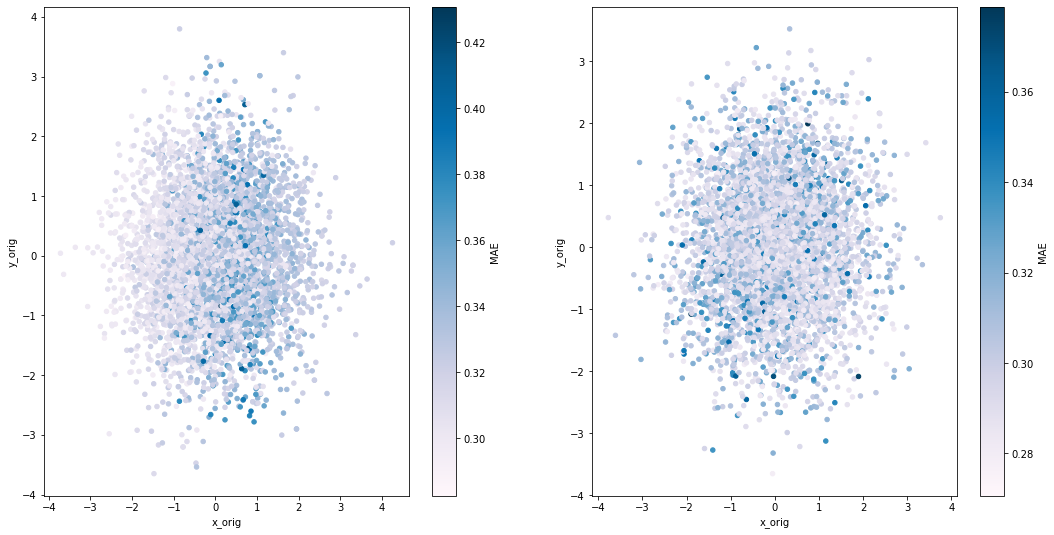

In [28]:
method = 'FeatureAblation'
xdf = pd.read_csv(f'/data/analysis/ag-reils/ag-reils-shared/cardioRS/results/interpretability/resample_multiplicities/evaluation/p0.00/x_{method}_51.csv')
ydf = pd.read_csv(f'/data/analysis/ag-reils/ag-reils-shared/cardioRS/results/interpretability/resample_multiplicities/evaluation/p0.00/y_{method}_51.csv')
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 9))
xdf.plot.scatter('x_orig', 'y_orig', c='MAE', cmap='PuBu', ax=ax1)
ydf.plot.scatter('x_orig', 'y_orig', c='MAE', cmap='PuBu', ax=ax2)

In [37]:
xdf

,Unnamed: 0,x_orig,y_orig,x_resampling,time,event,resampling_diff,model_diff,change_slope,change_slope_norm,attribution_x,attribution_norm_x,squared_error,absolute_error,MAE,MSE,RMSE
0,0,0.348720,0.389544,"[-0.3359962421121104, 0.0757522714949251, -0.8...",0.791166,1.0,"[0.6847161281312388, 0.2729676145242033, 1.215...",[0.3381509482860565],"[0.4938556788620634, 1.2387951181515475, 0.278...","[0.0208497277790384, 0.029269628158292958, 0.0...",0.172158,0.122118,"[0.010255334152582814, 0.06547195095105596, 0....","[0.10126862373204651, 0.2558748736219638, 0.45...",0.242663,0.096628,0.310850
1,1,0.784569,0.446195,"[-0.1530040531730433, 1.087602749330351, 0.819...",0.806355,1.0,"[0.9375727475942667, 0.3030340549091277, 0.034...",[0.3504507541656494],"[0.373785133009547, 1.1564731702208875, 10.055...","[0.01578055817654662, 0.027324566565870696, 0....",0.401986,0.285145,"[0.011307726291258976, 0.06647111899395025, 0....","[0.10633779333453829, 0.2578199352143861, 0.14...",0.240124,0.089398,0.298994
2,2,1.209356,1.314928,"[0.9367276467400668, 0.1407234548299741, 0.212...",0.000000,0.0,"[0.2726279408110882, 1.068632132721181, 0.9970...",[0.24677962064743042],"[0.9051882940290085, 0.23093037640467265, 0.24...","[0.038215475344464574, 0.005456306816824659, 0...",0.647844,0.459541,"[0.007039692629031228, 0.07822548640190281, 0....","[0.08390287616662034, 0.2796881949634321, 0.45...",0.237637,0.090024,0.300040
3,3,0.233735,-0.274223,"[-1.7405027677917992, -0.5069073641056587, 0.0...",0.878572,1.0,"[1.9742376039544363, 0.7406422002682957, 0.171...",[-0.554395318031311],"[-0.2808148912374308, -0.7485332564502573, -3....","[-0.011855516275709403, -0.01768596740444606, ...",0.113065,0.080201,"[0.017948997249753445, 0.09170629306662727, 0....","[0.13397386778679432, 0.30283046918470286, 0.5...",0.251621,0.099312,0.315138
4,4,-0.612208,0.822774,"[1.7694521637651923, -0.4403750472000197, -1.4...",0.920771,1.0,"[2.381660448933591, 0.17183323796837907, 0.837...",[-0.2585044503211975],"[-0.10853959070317733, -1.5043914284427775, -0...","[-0.004582352732328443, -0.035545004230196305,...",-0.315654,-0.223905,"[0.0160530684557769, 0.10284175926522843, 0.22...","[0.12670070424341334, 0.3206895060104531, 0.46...",0.240753,0.091566,0.302599
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5095,5095,-2.713351,-2.496023,"[0.0105750265863676, -0.7937752253749618, -0.4...",1.142518,1.0,"[2.7239258022415243, 1.9195755502801948, 2.251...",[-1.936706781387329],"[-0.7109983611864937, -1.008924489116687, -0.8...","[-0.03001711414200681, -0.02383836051945797, -...",-1.284429,-0.903785,"[0.02314519990948305, 0.0954704091949245, 0.23...","[0.15213546565309172, 0.3089828622997148, 0.48...",0.240253,0.091711,0.302839
5096,5096,0.309199,-0.334600,"[1.4345700560264594, 1.6163265076751128, -0.15...",0.842824,1.0,"[1.1253710448337375, 1.307127496482391, 0.4632...",[-0.25225427746772766],"[-0.224152095102994, -0.1929836822701449, -0.5...","[-0.009463311578733286, -0.004559721408245234,...",0.150985,0.107100,"[0.017313734061482424, 0.0839285369332534, 0.2...","[0.1315816630898182, 0.28970422318850203, 0.47...",0.252196,0.101379,0.318401
5097,5097,0.748925,0.182532,"[-0.0265191369169419, -0.3005558763207619, 0.5...",0.307402,1.0,"[0.775444065070997, 1.049480804474817, 0.18374...",[1.2477068901062012],"[1.6090224250951815, 1.1888801441495453, 6.790...","[0.06793012815181738, 0.02809026225091881, 0.2...",0.381605,0.270687,"[0.002936363550833867, 0.06607688206000627, 0....","[0.054188223359267526, 0.257054239529338, 0.24...",0.271654,0.119899,0.346264
5098,5098,-0.567965,-0.505648,"[-0.5771746694021446, -0.4294065409476704, -1....",0.895207,1.0,"[0.00920977065479156, 0.13855835779968262, 1.1...",[0.7280232906341553],"[79.04901413102911, 5.25427193418875, 0.655971...","[1.0, 0.12414529529768903, 0.02055644626512461...",-0.278445,-0.197512,"[0.7706761887536152, 0.02592074448801649, 0.19...","[0.8778816484889151, 0.16099920648256777, 0.43...",0.275062,0.132

In [38]:
ydf

,Unnamed: 0,x_orig,y_orig,y_resampling,time,event,resampling_diff,model_diff,change_slope,change_slope_norm,attribution_y,attribution_y_norm,squared_error,absolute_error,MAE,MSE,RMSE
0,5100,-0.278802,-1.030245,"[-1.0301485789046454, -1.0303048562970307, -1....",1.077724,1.0,"[9.689070645668707e-05, 5.9386685928641825e-05...",[-2.6524066925048828e-05],"[-0.2737524360698706, -0.4466332227550088, -0....","[-0.015203563469787806, -0.020139464755984406,...",-0.345813,-0.365727,"[0.12286694952483126, 0.024020060125042198, 0....","[0.3505238216224844, 0.15498406410028806, 0.12...",0.274034,0.135036,0.367473
1,5101,0.003796,-0.526641,"[-0.5267403958735543, -0.5265308847512551, -0....",0.000000,0.0,"[9.974053488748247e-05, 0.00010977058741168388...",[-4.6893954277038574e-05],"[-0.470159442496872, -0.4271996295434529, -0.7...","[-0.026111544531047807, -0.01926317041506622, ...",-0.165588,-0.175124,"[0.115338919160107, 0.02429245133342129, 0.010...","[0.3396158405612244, 0.15586035844120624, 0.10...",0.286877,0.145461,0.381393
2,5102,0.492937,-0.436486,"[-0.4365112635176056, -0.4365116391205123, -0....",0.831821,1.0,"[2.4885576647704077e-05, 2.5261179554370017e-0...",[-6.105005741119385e-05],"[-2.4532305710836835, -2.4167540268574905, -0....","[-0.13624662935958287, -0.10897562041522804, -...",-0.135264,-0.143054,"[0.05266141725164623, 0.0043755457911247965, 0...","[0.22948075573268933, 0.06614790844104443, 0.1...",0.314016,0.174885,0.418193
3,5103,0.540490,0.575423,"[0.575359699015357, 0.5751839246409128, 0.5750...",0.369287,0.0,"[6.309433586360047e-05, 0.00023886871030776025...",[7.838010787963867e-06],"[0.12422685302383325, 0.03281304938543569, 0.0...","[0.006899265890433188, 0.0014795971682492733, ...",0.171999,0.181904,"[0.13885062102258697, 0.03118866412163311, 0.0...","[0.3726266509827054, 0.17660312602452174, 0.14...",0.251775,0.111507,0.333927
4,5104,-0.145096,0.018426,"[0.0185383270552378, 0.0186081869326833, 0.018...",0.000000,0.0,"[0.00011246239675430023, 0.0001823222741998004...",[-2.808868885040283e-06],"[-0.02497607170134297, -0.015406065426554219, ...","[-0.001387112008166461, -0.0006946861448698603...",0.005606,0.005929,"[0.13274383459100078, 0.03042542116963923, 0.0...","[0.36434027308410577, 0.1744288427114026, 0.14...",0.249375,0.109565,0.331006
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,10095,0.820011,-0.339785,"[-0.3399379925657323, -0.3398732918265245, -0....",0.884036,1.0,"[0.00015333074227580346, 8.863000306796875e-05...",[1.8924474716186523e-05],"[0.12342257289895689, 0.21352221664342813, 0.2...","[0.0068545980726720124, 0.009628086173671824, ...",-0.103236,-0.109181,"[0.1388173341791228, 0.03413315925617274, 0.02...","[0.37258198316494423, 0.1847516150299443, 0.15...",0.254105,0.115665,0.340096
4996,10096,-1.639622,-1.851417,"[-1.8513856894001797, -1.8516029323117376, -1....",1.272588,1.0,"[3.1465192620316884e-05, 0.0001857777189375742...",[-2.0742416381835938e-05],"[-0.6592178421448049, -0.11165179818364487, -0...","[-0.03661140133528178, -0.00503457275433186, -...",-0.633421,-0.669899,"[0.10831733076433157, 0.02893025298784788, 0.0...","[0.3291159837569904, 0.1700889561019406, 0.132...",0.262614,0.124454,0.352781
4997,10097,1.218561,1.083832,"[1.0838042543259063, 1.083688676844152, 1.0838...",0.883149,1.0,"[2.79071432707223e-05, 0.00014348462502500325,...",[-1.1920928955078125e-06],"[-0.04271640719164726, -0.008308157722822788, ...","[-0.0023723683239616927, -0.00037462920607169,...",0.323177,0.341789,"[0.1320268682106992, 0.03053717792895594, 0.01...","[0.3633550167683105, 0.17474889965020077, 0.14...",0.248056,0.109274,0.330566
4998,10098,1.644935,0.250605,"[0.2505249169304174, 0.2506734271912257, 0.250...",0.714526,1.0,"[7.962592671378887e-05, 6.88843340945211e-05, ...",[2.2172927856445312e-05],"[0.2784636709616544, 0.32188636426419187, 1.17...","[0.015465214323846444, 0.014514413075998503, 0...",0.070720,0.074793,"[0.1453077978496175, 0.03596254902030737, 0.04...","[0.381

In [ ]:
## Aggregate first and then norm

<AxesSubplot:xlabel='x_orig', ylabel='y_orig'>

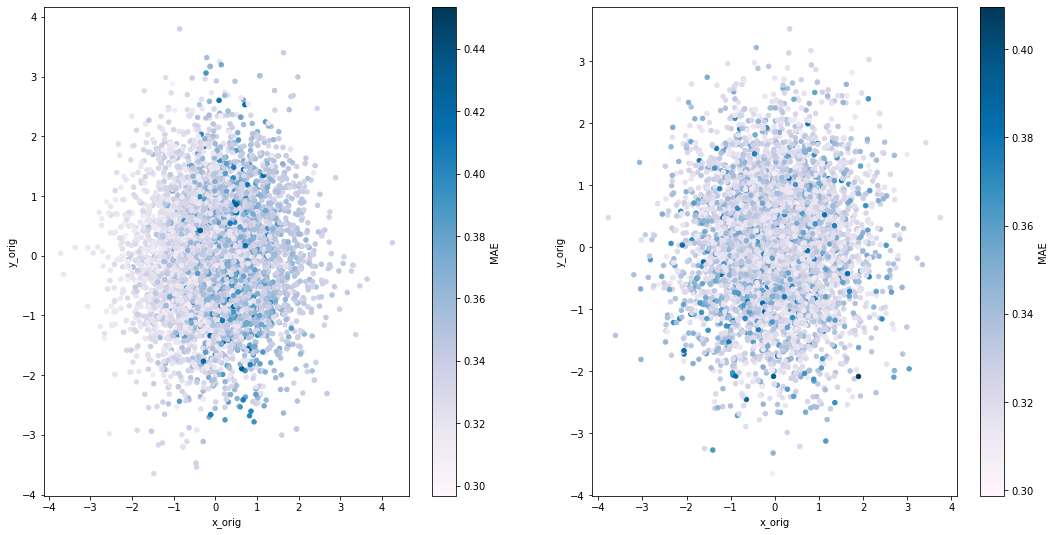

In [29]:
method = 'KernelExplainer'
seed = 77
exp_id = 'p0.00'
xdf = pd.read_csv(f'/data/analysis/ag-reils/ag-reils-shared/cardioRS/results/interpretability/resample_multiplicities/evaluation/p0.00/x_{method}_{seed}.csv')
ydf = pd.read_csv(f'/data/analysis/ag-reils/ag-reils-shared/cardioRS/results/interpretability/resample_multiplicities/evaluation/p0.00/y_{method}_{seed}.csv')
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 9))
xdf.plot.scatter('x_orig', 'y_orig', c='MAE', cmap='PuBu', ax=ax1)
ydf.plot.scatter('x_orig', 'y_orig', c='MAE', cmap='PuBu', ax=ax2)

<AxesSubplot:xlabel='x_orig', ylabel='y_orig'>

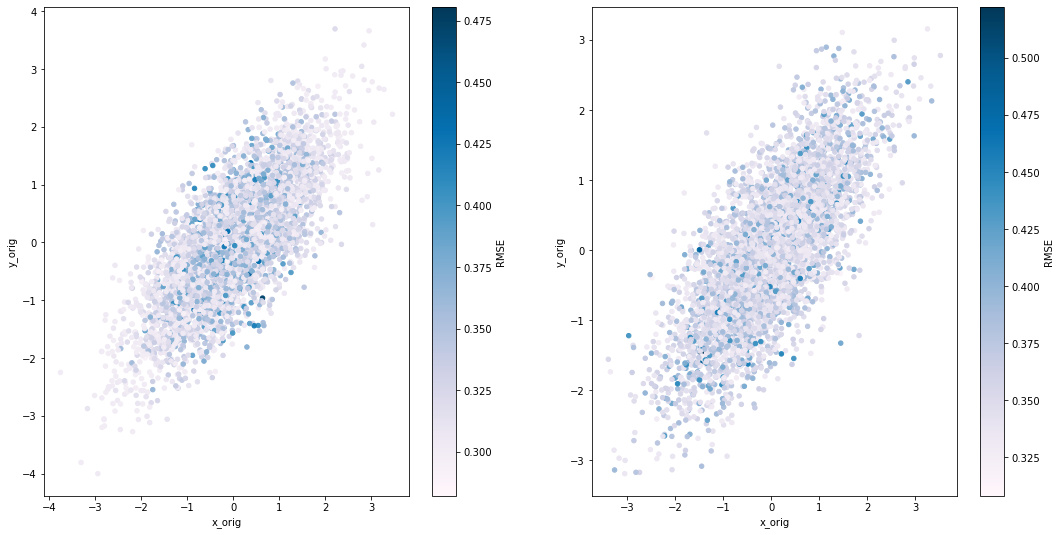

In [34]:
method = 'FeatureAblation'
seed = 151
exp_id = 'p0.75'
xdf = pd.read_csv(f'/data/analysis/ag-reils/ag-reils-shared/cardioRS/results/interpretability/resample_multiplicities/evaluation/{exp_id}/x_{method}_{seed}.csv')
ydf = pd.read_csv(f'/data/analysis/ag-reils/ag-reils-shared/cardioRS/results/interpretability/resample_multiplicities/evaluation/{exp_id}/y_{method}_{seed}.csv')
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 9))
xdf.plot.scatter('x_orig', 'y_orig', c='RMSE', cmap='PuBu', ax=ax1)
ydf.plot.scatter('x_orig', 'y_orig', c='RMSE', cmap='PuBu', ax=ax2)

In [35]:
xdf

,Unnamed: 0,x_orig,y_orig,x_resampling,time,event,resampling_diff,model_diff,change_slope,change_slope_norm,attribution_x,attribution_norm_x,squared_error,absolute_error,MAE,MSE,RMSE
0,0,0.348720,0.389544,"[-0.3359962421121104, 0.0757522714949251, -0.8...",0.791166,1.0,"[0.6847161281312388, 0.2729676145242033, 1.215...",[0.3381509482860565],"[0.4938556788620634, 1.2387951181515475, 0.278...","[0.0208497277790384, 0.029269628158292958, 0.0...",0.172158,0.122118,"[0.010255334152582814, 0.06547195095105596, 0....","[0.10126862373204651, 0.2558748736219638, 0.45...",0.242663,0.096628,0.310850
1,1,0.784569,0.446195,"[-0.1530040531730433, 1.087602749330351, 0.819...",0.806355,1.0,"[0.9375727475942667, 0.3030340549091277, 0.034...",[0.3504507541656494],"[0.373785133009547, 1.1564731702208875, 10.055...","[0.01578055817654662, 0.027324566565870696, 0....",0.401986,0.285145,"[0.011307726291258976, 0.06647111899395025, 0....","[0.10633779333453829, 0.2578199352143861, 0.14...",0.240124,0.089398,0.298994
2,2,1.209356,1.314928,"[0.9367276467400668, 0.1407234548299741, 0.212...",0.000000,0.0,"[0.2726279408110882, 1.068632132721181, 0.9970...",[0.24677962064743042],"[0.9051882940290085, 0.23093037640467265, 0.24...","[0.038215475344464574, 0.005456306816824659, 0...",0.647844,0.459541,"[0.007039692629031228, 0.07822548640190281, 0....","[0.08390287616662034, 0.2796881949634321, 0.45...",0.237637,0.090024,0.300040
3,3,0.233735,-0.274223,"[-1.7405027677917992, -0.5069073641056587, 0.0...",0.878572,1.0,"[1.9742376039544363, 0.7406422002682957, 0.171...",[-0.554395318031311],"[-0.2808148912374308, -0.7485332564502573, -3....","[-0.011855516275709403, -0.01768596740444606, ...",0.113065,0.080201,"[0.017948997249753445, 0.09170629306662727, 0....","[0.13397386778679432, 0.30283046918470286, 0.5...",0.251621,0.099312,0.315138
4,4,-0.612208,0.822774,"[1.7694521637651923, -0.4403750472000197, -1.4...",0.920771,1.0,"[2.381660448933591, 0.17183323796837907, 0.837...",[-0.2585044503211975],"[-0.10853959070317733, -1.5043914284427775, -0...","[-0.004582352732328443, -0.035545004230196305,...",-0.315654,-0.223905,"[0.0160530684557769, 0.10284175926522843, 0.22...","[0.12670070424341334, 0.3206895060104531, 0.46...",0.240753,0.091566,0.302599
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5095,5095,-2.713351,-2.496023,"[0.0105750265863676, -0.7937752253749618, -0.4...",1.142518,1.0,"[2.7239258022415243, 1.9195755502801948, 2.251...",[-1.936706781387329],"[-0.7109983611864937, -1.008924489116687, -0.8...","[-0.03001711414200681, -0.02383836051945797, -...",-1.284429,-0.903785,"[0.02314519990948305, 0.0954704091949245, 0.23...","[0.15213546565309172, 0.3089828622997148, 0.48...",0.240253,0.091711,0.302839
5096,5096,0.309199,-0.334600,"[1.4345700560264594, 1.6163265076751128, -0.15...",0.842824,1.0,"[1.1253710448337375, 1.307127496482391, 0.4632...",[-0.25225427746772766],"[-0.224152095102994, -0.1929836822701449, -0.5...","[-0.009463311578733286, -0.004559721408245234,...",0.150985,0.107100,"[0.017313734061482424, 0.0839285369332534, 0.2...","[0.1315816630898182, 0.28970422318850203, 0.47...",0.252196,0.101379,0.318401
5097,5097,0.748925,0.182532,"[-0.0265191369169419, -0.3005558763207619, 0.5...",0.307402,1.0,"[0.775444065070997, 1.049480804474817, 0.18374...",[1.2477068901062012],"[1.6090224250951815, 1.1888801441495453, 6.790...","[0.06793012815181738, 0.02809026225091881, 0.2...",0.381605,0.270687,"[0.002936363550833867, 0.06607688206000627, 0....","[0.054188223359267526, 0.257054239529338, 0.24...",0.271654,0.119899,0.346264
5098,5098,-0.567965,-0.505648,"[-0.5771746694021446, -0.4294065409476704, -1....",0.895207,1.0,"[0.00920977065479156, 0.13855835779968262, 1.1...",[0.7280232906341553],"[79.04901413102911, 5.25427193418875, 0.655971...","[1.0, 0.12414529529768903, 0.02055644626512461...",-0.278445,-0.197512,"[0.7706761887536152, 0.02592074448801649, 0.19...","[0.8778816484889151, 0.16099920648256777, 0.43...",0.275062,0.132

In [36]:
ydf

,Unnamed: 0,x_orig,y_orig,y_resampling,time,event,resampling_diff,model_diff,change_slope,change_slope_norm,attribution_y,attribution_y_norm,squared_error,absolute_error,MAE,MSE,RMSE
0,5100,-0.278802,-1.030245,"[-1.0301485789046454, -1.0303048562970307, -1....",1.077724,1.0,"[9.689070645668707e-05, 5.9386685928641825e-05...",[-2.6524066925048828e-05],"[-0.2737524360698706, -0.4466332227550088, -0....","[-0.015203563469787806, -0.020139464755984406,...",-0.345813,-0.365727,"[0.12286694952483126, 0.024020060125042198, 0....","[0.3505238216224844, 0.15498406410028806, 0.12...",0.274034,0.135036,0.367473
1,5101,0.003796,-0.526641,"[-0.5267403958735543, -0.5265308847512551, -0....",0.000000,0.0,"[9.974053488748247e-05, 0.00010977058741168388...",[-4.6893954277038574e-05],"[-0.470159442496872, -0.4271996295434529, -0.7...","[-0.026111544531047807, -0.01926317041506622, ...",-0.165588,-0.175124,"[0.115338919160107, 0.02429245133342129, 0.010...","[0.3396158405612244, 0.15586035844120624, 0.10...",0.286877,0.145461,0.381393
2,5102,0.492937,-0.436486,"[-0.4365112635176056, -0.4365116391205123, -0....",0.831821,1.0,"[2.4885576647704077e-05, 2.5261179554370017e-0...",[-6.105005741119385e-05],"[-2.4532305710836835, -2.4167540268574905, -0....","[-0.13624662935958287, -0.10897562041522804, -...",-0.135264,-0.143054,"[0.05266141725164623, 0.0043755457911247965, 0...","[0.22948075573268933, 0.06614790844104443, 0.1...",0.314016,0.174885,0.418193
3,5103,0.540490,0.575423,"[0.575359699015357, 0.5751839246409128, 0.5750...",0.369287,0.0,"[6.309433586360047e-05, 0.00023886871030776025...",[7.838010787963867e-06],"[0.12422685302383325, 0.03281304938543569, 0.0...","[0.006899265890433188, 0.0014795971682492733, ...",0.171999,0.181904,"[0.13885062102258697, 0.03118866412163311, 0.0...","[0.3726266509827054, 0.17660312602452174, 0.14...",0.251775,0.111507,0.333927
4,5104,-0.145096,0.018426,"[0.0185383270552378, 0.0186081869326833, 0.018...",0.000000,0.0,"[0.00011246239675430023, 0.0001823222741998004...",[-2.808868885040283e-06],"[-0.02497607170134297, -0.015406065426554219, ...","[-0.001387112008166461, -0.0006946861448698603...",0.005606,0.005929,"[0.13274383459100078, 0.03042542116963923, 0.0...","[0.36434027308410577, 0.1744288427114026, 0.14...",0.249375,0.109565,0.331006
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,10095,0.820011,-0.339785,"[-0.3399379925657323, -0.3398732918265245, -0....",0.884036,1.0,"[0.00015333074227580346, 8.863000306796875e-05...",[1.8924474716186523e-05],"[0.12342257289895689, 0.21352221664342813, 0.2...","[0.0068545980726720124, 0.009628086173671824, ...",-0.103236,-0.109181,"[0.1388173341791228, 0.03413315925617274, 0.02...","[0.37258198316494423, 0.1847516150299443, 0.15...",0.254105,0.115665,0.340096
4996,10096,-1.639622,-1.851417,"[-1.8513856894001797, -1.8516029323117376, -1....",1.272588,1.0,"[3.1465192620316884e-05, 0.0001857777189375742...",[-2.0742416381835938e-05],"[-0.6592178421448049, -0.11165179818364487, -0...","[-0.03661140133528178, -0.00503457275433186, -...",-0.633421,-0.669899,"[0.10831733076433157, 0.02893025298784788, 0.0...","[0.3291159837569904, 0.1700889561019406, 0.132...",0.262614,0.124454,0.352781
4997,10097,1.218561,1.083832,"[1.0838042543259063, 1.083688676844152, 1.0838...",0.883149,1.0,"[2.79071432707223e-05, 0.00014348462502500325,...",[-1.1920928955078125e-06],"[-0.04271640719164726, -0.008308157722822788, ...","[-0.0023723683239616927, -0.00037462920607169,...",0.323177,0.341789,"[0.1320268682106992, 0.03053717792895594, 0.01...","[0.3633550167683105, 0.17474889965020077, 0.14...",0.248056,0.109274,0.330566
4998,10098,1.644935,0.250605,"[0.2505249169304174, 0.2506734271912257, 0.250...",0.714526,1.0,"[7.962592671378887e-05, 6.88843340945211e-05, ...",[2.2172927856445312e-05],"[0.2784636709616544, 0.32188636426419187, 1.17...","[0.015465214323846444, 0.014514413075998503, 0...",0.070720,0.074793,"[0.1453077978496175, 0.03596254902030737, 0.04...","[0.381

<AxesSubplot:xlabel='x_orig', ylabel='y_orig'>

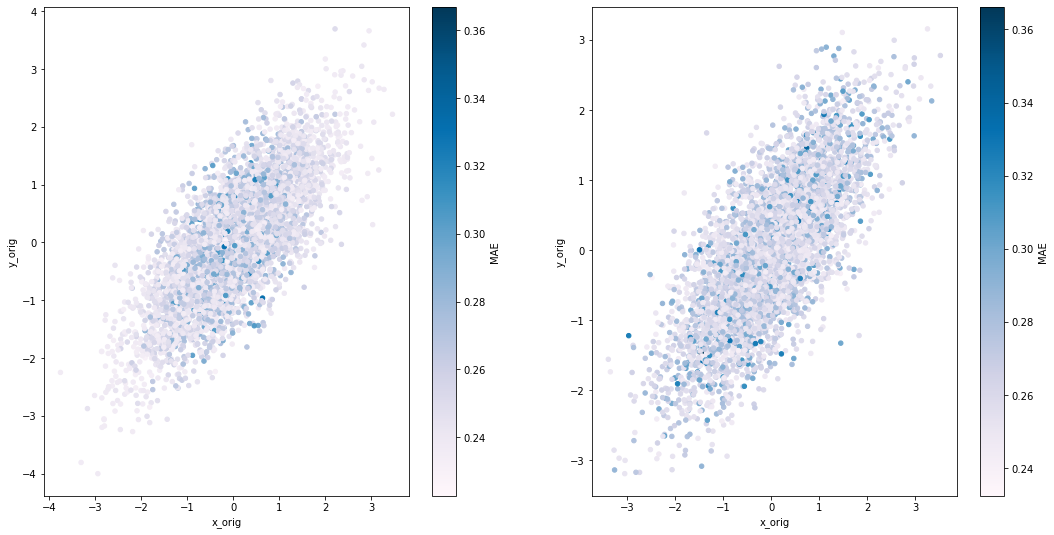

In [31]:
method = 'KernelExplainer'
seed = 77
exp_id = 'p0.75'
xdf = pd.read_csv(f'/data/analysis/ag-reils/ag-reils-shared/cardioRS/results/interpretability/resample_multiplicities/evaluation/{exp_id}/x_{method}_{seed}.csv')
ydf = pd.read_csv(f'/data/analysis/ag-reils/ag-reils-shared/cardioRS/results/interpretability/resample_multiplicities/evaluation/{exp_id}/y_{method}_{seed}.csv')
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 9))
xdf.plot.scatter('x_orig', 'y_orig', c='MAE', cmap='PuBu', ax=ax1)
ydf.plot.scatter('x_orig', 'y_orig', c='MAE', cmap='PuBu', ax=ax2)

In [ ]:
def get_mean_error(experiment_id, method):
    """
    :param experiment_id: experiment id
    :param method: attribution method
    :return: None -> prints the error graph
    """
    api = wandb.Api()
    runs =  api.runs('cardiors/interpretability',
                     filters={"$and": [{'tags': f'{experiment_id}'}, {'state': 'finished'}]})
    print('len runs:', len(runs))
    for run in runs:
        deets_x, deets_y = change_slope_singular(run, method)


    valid_attr_x = []
    valid_attr_y = []
    dir = os.listdir(f'/data/analysis/ag-reils/ag-reils-shared/cardioRS/results/interpretability/resample_multiplicities/evaluation/{experiment_id}')
    change_slope_path = f'/data/analysis/ag-reils/ag-reils-shared/cardioRS/results/interpretability/correlation_case/{experiment_id}/change_slope/'
    for attr in dir:
        dim = attr.split('_')[0]
        name = attr.split('_')[1]
        seed = attr.split('_')[2]
        if dim == 'x' and name == method:
            valid_attr_x.append(pd.read_csv(f'{change_slope_path}/{attr}', index_col=0))
        elif dim == 'y' and name == method:
            valid_attr_y.append(pd.read_csv(f'{change_slope_path}/{attr}', index_col=0))

    err_x = None
    err_y = None
    for attr in valid_attr_x:
        error_x = attr['error'].to_numpy().reshape(-1, 1)
        err_x = error_x if err_x is None else np.concatenate((err_x, error_x), axis=1)
    mean_error_x = np.mean(err_x, axis=1)
    deets_x.loc[:, 'mean_error'] = mean_error_x

    for attr in valid_attr_y:
        error_y = attr['error'].to_numpy().reshape(-1, 1)
        if np.isnan(error_y).any():
            continue
        err_y = error_y if err_y is None else np.concatenate((err_y, error_y), axis=1)
    mean_error_y = np.mean(err_y, axis=1)
    deets_y.loc[:, 'mean_error'] = mean_error_y

    # plot figures
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 9))
    fig.suptitle(method, fontsize=35)
    dim0_mean = deets_x['mean_error'].mean()
    dim1_mean = deets_y['mean_error'].mean()
    ax1.set_title(f"dimension 0 error: {dim0_mean}", fontdict=dict(fontsize=20))
    ax2.set_title(f"dimension 1 error: {dim1_mean}", fontdict=dict(fontsize=20))
    deets_x.plot.scatter('x_orig', 'y_orig', c='mean_error', cmap='PuBu', vmax=1.9, vmin=0.0, ax=ax1)
    deets_y.plot.scatter('x_orig', 'y_orig', c='mean_error', cmap='PuBu', vmax=1.9, vmin=0.0, ax=ax2)
    deets_x.to_csv(f'{RESULTS_DIR}/{experiment_id}/change_slope/MeanError_x_{method}.csv')
    deets_y.to_csv(f'{RESULTS_DIR}/{experiment_id}/change_slope/MeanError_y_{method}.csv')

    return deets_x, deets_y, err_x, err_y